In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.3.1


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1341s 16us/step


In [4]:
os.listdir(dataset_dir)

['test', 'train', 'imdb.vocab', 'imdbEr.txt', 'README']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'labeledBow.feat',
 'unsup',
 'urls_neg.txt',
 'urls_pos.txt',
 'pos',
 'neg',
 'unsupBow.feat']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.

In [7]:
#As the IMDB dataset contains additional folders, you will remove them before using this utility.
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

**Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data. ***

 # Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.




In [8]:
# A random seed (or seed state, or just seed) is a number (or vector) used to initialize a pseudorandom number generator.

In [13]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=32, 
                                                                  validation_split=0.2,
                                                                  subset='training', 
                                                                  seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('review : ' , text_batch.numpy()[i])
    print('label : ' , label_batch.numpy()[i])

review :  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label :  0
review :  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they 

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [16]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [18]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).

Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

In [19]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values

In [20]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


Next, you will call adapt to fit the state of the preprocessing layer to the dataset. 
This will cause the model to build an index of strings to integers.


***Note:*** it's important to only use your training data when calling adapt (using the test set would leak information).

In [21]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

In [22]:
for i in train_text.take(1):
  print(i.shape)

(32,)


In [23]:
image = tf.zeros([10,10,3])
expand_image = tf.expand_dims(image, axis=0)

In [24]:
# expand_image

In [25]:
# image

In [26]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [27]:
# retrieve a batch (of 32 reviews and labels) from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review : ", first_review)
print("Label : ", raw_train_ds.class_names[first_label])
print("Vectorized Review : ", vectorize_text(first_review, first_label))

Review :  tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label :  neg
Vectorized Review :  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [28]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [29]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Create the model
It's time to create our neural network:

In [39]:
embedding_dim = 16

In [40]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model
You will train the model by passing the dataset object to the fit method.

In [45]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10)

Epoch 1/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4347 - binary_accuracy: 0.9015 - val_loss: 0.4156 - val_binary_accuracy: 0.8742
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3515 - binary_accuracy: 0.9039 - val_loss: 0.3595 - val_binary_accuracy: 0.8776
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3014 - binary_accuracy: 0.9076 - val_loss: 0.3273 - val_binary_accuracy: 0.8804
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.2691 - binary_accuracy: 0.9104 - val_loss: 0.3082 - val_binary_accuracy: 0.8820
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.2462 - binary_accuracy: 0.9165 - val_loss: 0.2967 - val_binary_accuracy: 0.8842
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2295 - binary_accuracy: 0.9212 - val_loss: 0.2894 - val_binary_accuracy: 0.8860
Epoch 7/10
625/625 [==============================] - 6s 1

In [46]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3084 - binary_accuracy: 0.8738
Loss:  0.3083527088165283
Accuracy:  0.8738399744033813


In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

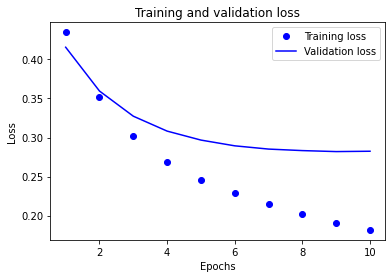

In [49]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

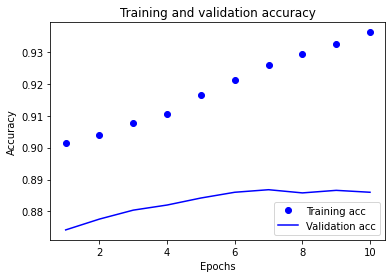

In [50]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [51]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3084 - accuracy: 0.8738
0.8738399744033813


In [52]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

In [53]:
export_model.predict(examples)

array([[0.6013355 ],
       [0.4010496 ],
       [0.33905956]], dtype=float32)